<a href="https://colab.research.google.com/github/j-gorzala/PA-projekt/blob/main/PA_projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://medium.com/nanonets/how-to-easily-build-a-dog-breed-image-classification-model-2fd214419cde

# tf 2.0
# https://www.tensorflow.org/tutorials/images/cnn

# save and load models
# https://www.tensorflow.org/tutorials/keras/save_and_load


# https://cg.cs.tsinghua.edu.cn/ThuDogs/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
import numpy as np

import tarfile
import zipfile
import os
import gc

import random
import math

import time
from datetime import timedelta

import PIL.Image
from IPython.display import display
import pickle
import collections

from scipy.stats import itemfreq

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Otwieranie pliku images.tar z dysku google
file = zipfile.ZipFile("drive/MyDrive/low-resolution.zip", "r") # zdjęcia ze zbioru Tsinghua
#tarfile.open("drive/MyDrive/images.tar") # zdjęcia ze zbioru Stanford

# Ekstrakcja danych
file.extractall('./')
file.close()

# Podział na zbiór treningowy i testowy

In [3]:
min_breed_images_n = 2000
train_test_split = 0.7

# Podział zbioru na train i test (odpowiednie słowniki zawierające listy id_zdjęć jako wartości i id_ras jako klucze)
train_dict = {}
test_dict = {}

random.seed(123)
for breed in os.listdir("low-resolution"):
  try:
  # Listowanie wszystkich id dla danej rasy
    current_breed_ids = [os.listdir(f"low-resolution/{breed}")][0]
    if len(current_breed_ids) >= min_breed_images_n:
      # Podział na zbiór i test
      current_breed_train_ids = random.sample(current_breed_ids, math.floor(train_test_split * len(current_breed_ids)))
      current_breed_test_ids = [image_id for image_id in current_breed_ids if image_id not in current_breed_train_ids]
      # Przypisanie rasy i id_zdjeć do odpowiedniego słownika
      train_dict[breed] = current_breed_train_ids
      test_dict[breed] = current_breed_test_ids
  except:
    pass

In [4]:
def list_train_test_paths(train_test):
  if train_test == 'train':
    set_dict = train_dict
  elif train_test == 'test':
    set_dict = test_dict

  set_images_paths = []
  for breed_id, breed_images in set_dict.items():
    for image_id in breed_images:
      current_image_path = f'low-resolution/{breed_id}/{image_id}'
      set_images_paths.append(current_image_path)

  return set_images_paths

# Tworzenie pickle

In [5]:
def images_to_pickle(train_test, nwidth, nheight):

    set_list = list_train_test_paths(train_test)
    start_time = time.time()
    
    s = (len(set_list), nwidth, nheight, 3)
    allImage = np.zeros(s)
    images_path = []
    i = 0
    for filename in set_list:
      if filename is not None:
        try:
          image = PIL.Image.open(filename)
          image = image.resize((nwidth, nheight))
          image = np.array(image)
          image = np.clip(image/255.0, 0.0, 1.0)
          images_path.append(filename)
          allImage[i]=image
          i += 1
        except:
          pass

    pickle.dump((allImage, images_path), open(train_test + '.pkl', "wb" ) )
    end_time = time.time()
    time_dif = end_time - start_time
    print(f"Total time of the {train_test} set conversion: " + str(timedelta(seconds=int(round(time_dif)))))

In [6]:
# Konwersja zdjęć
image_resize = 64

images_to_pickle(train_test = 'train', nwidth = image_resize, nheight = image_resize)
images_to_pickle(train_test = 'test', nwidth = image_resize, nheight = image_resize)

Total time of the train set conversion: 0:02:31
Total time of the test set conversion: 0:01:10


# Wczytywanie pickle

In [34]:
# load TRAIN
train_tuple = pickle.load(open( "train.pkl", "rb" ))
train = train_tuple[0]
images_path_train = train_tuple[1]
print(train.shape)

# load TEST
test_tuple = pickle.load(open( "test.pkl", "rb" ))
test = test_tuple[0]
images_path_test = test_tuple[1]
print(test.shape)

(25032, 64, 64, 3)
(10733, 64, 64, 3)


In [31]:
# Czyszczenie RAM
del current_breed_train_ids, current_breed_test_ids, current_breed_ids, train_tuple, test_tuple
gc.collect()

174

## drugi index jest po wierszach, tzn. 80 oznacza y=80 i wszystkie pixele po kolejnych x

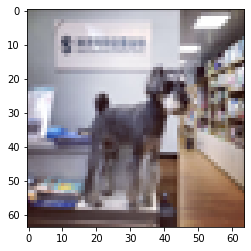

low-resolution/2342-n000102-miniature_schnauzer/n130711.jpg


In [32]:
# Train set - sprawdzanie po indeksach
i = 1
lum_img = train[i,:,:,:]
plt.imshow(lum_img)
plt.show()
print(images_path_train[i])

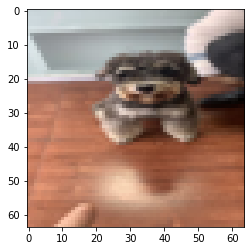

NameError: ignored

In [33]:
# Test set - sprawdzanie po indeksach
i = 1
lum_img = test[i,:,:,:]
plt.imshow(lum_img)
plt.show()
print(images_path_test[i])

In [6]:
# Tworzenie df z liczbą zdjęć dla poszczególynch ras

train_labels = np.array([breed.split('/')[1].split('-')[2] for breed in images_path_train])
test_labels = np.array([breed.split('/')[1].split('-')[2] for breed in images_path_test])

train_count_df = pd.DataFrame.from_dict(collections.Counter(train_labels), orient='index', columns=['count']).sort_values(['count'], ascending=False)
test_count_df = pd.DataFrame.from_dict(collections.Counter(test_labels), orient='index', columns=['count']).sort_values(['count'], ascending=False)

In [7]:
fig_breeds_train = px.bar(train_count_df, x='count', y=train_count_df.index, orientation='h', title="Liczebność poszczególnych ras dla zbioru treningowego")
fig_breeds_train.show()

In [8]:
fig_breeds_test = px.bar(test_count_df, x='count', y=test_count_df.index, orientation='h', title="Liczebność poszczególnych ras dla zbioru testowego")
fig_breeds_test.show()

## Przekodowanie zmiennej celu (etykiety)

In [9]:
train_labels = train_labels.reshape(train_labels.shape[0], 1)
test_labels = test_labels.reshape(test_labels.shape[0],1)

labels_dict = {label:i for i,label in enumerate(np.unique(test_labels))}
print(labels_dict)

def transform_labels(labels, labels_dict):
    labels_output = []
    n_labels = len(labels_dict)
    for i in range(0, len(labels)):
      breed = labels[i][0]
      breed_index = labels_dict[breed]
      labels_output.append([breed_index])
    
    return np.array(labels_output)
  

train_obs_cls = np.array([labels_dict[label[0]] for label in train_labels])
test_obs_cls = np.array([labels_dict[label[0]] for label in test_labels])

train_labels_bin = transform_labels(train_labels, labels_dict)
test_labels_bin = transform_labels(test_labels, labels_dict)
print(train_labels_bin.shape)
print(test_labels_bin.shape)

{'Bichon_Frise': 0, 'Border_collie': 1, 'Cardigan': 2, 'Labrador_retriever': 3, 'Samoyed': 4, 'chinese_rural_dog': 5, 'golden_retriever': 6, 'miniature_schnauzer': 7, 'teddy': 8, 'toy_poodle': 9}
(25032, 1)
(10733, 1)


# Tworzenie sieci CNN - tensorflow 2.0

In [10]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(4,4), padding='same', activation='relu', input_shape=(80,80,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#model.add(Conv2D(filters=120, kernel_size=(5,5), padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 40, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0

In [11]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train, train_labels_bin, epochs=10, 
                      validation_data=(test, test_labels_bin))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



783/783 [==============================] - 27s 19ms/step - loss: 2.0508 - accuracy: 0.2583 - val_loss: 1.8774 - val_accuracy: 0.3143
Epoch 2/10
783/783 [==============================] - 11s 14ms/step - loss: 1.8736 - accuracy: 0.3173 - val_loss: 1.8160 - val_accuracy: 0.3527
Epoch 3/10
783/783 [==============================] - 11s 14ms/step - loss: 1.7926 - accuracy: 0.3551 - val_loss: 1.7271 - val_accuracy: 0.3899
Epoch 4/10
783/783 [==============================] - 11s 14ms/step - loss: 1.7400 - accuracy: 0.3754 - val_loss: 1.6846 - val_accuracy: 0.4063
Epoch 5/10
783/783 [==============================] - 11s 14ms/step - loss: 1.6650 - accuracy: 0.4073 - val_loss: 1.6783 - val_accuracy: 0.4054
Epoch 6/10
783/783 [==============================] - 11s 14ms/step - loss: 1.6044 - accuracy: 0.4229 - val_loss: 1.6437 - val_accuracy: 0.4245
Epoch 7/10
783/783 [==============================] - 10s 13ms/step - loss: 1.5419 - accuracy: 0.4460 - val_loss: 1.6931 - val_accuracy: 0.4098
Epo

In [12]:
metrics_df = pd.DataFrame(history.history)
metrics_df.tail()

,loss,accuracy,val_loss,val_accuracy
5,1.604422,0.422859,1.643679,0.424485
6,1.541941,0.446029,1.693128,0.409764
7,1.472106,0.470398,1.637672,0.428398
8,1.412524,0.491331,1.640297,0.440976
9,1.339615,0.514981,1.674362,0.436784


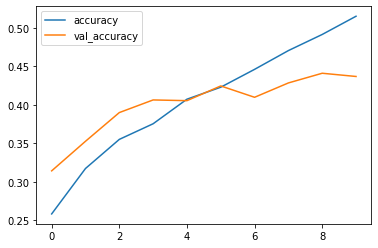

In [13]:
metrics_df[["accuracy","val_accuracy"]].plot()

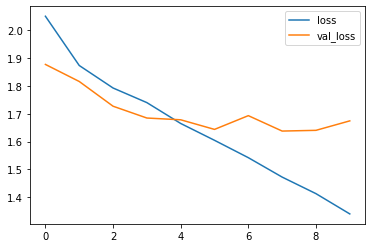

In [14]:
metrics_df[["loss","val_loss"]].plot()

# Tworzenie macierzy pomyłek

In [15]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 15
    
    fig, axes = plt.subplots(5, 3, figsize=(14,10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='binary')
        xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


def plot_confusion_matrix(data_obs_cls, data_predicted_cls, labels_dict):

    cm = confusion_matrix(y_true=data_obs_cls,
                          y_pred=data_predicted_cls)
    print(cm)
    plt.matshow(cm, cmap='coolwarm')

    plt.colorbar()
    num_classes = len(labels_dict)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Observed')
    plt.show()

    return np.asmatrix(cm)

In [ ]:
indices = random.sample(range(0, len(test_labels)), 15)

test_obs_cls = np.array([labels_dict[label[0]] for label in test_labels])
test_pred_cls = np.array([np.argmax(pred) for pred in model.predict(test)])

print(labels_dict)
plot_images(images=test[indices], cls_true=list(map(test_obs_cls.__getitem__, indices)), cls_pred=list(map(test_pred_cls.__getitem__, indices)))

[[ 568   12    8    1   39   13  119    0    7   30   22    5   23   72
     6]
 [  14  461   57    5   25    3   17    0   28   42   14   27   47   35
     4]
 [  16   64  412    1   22   10    9    3   16   49  163   16   34   57
     1]
 [  30   33   34    2   29    4   22    0    7   31   24   10   57   51
     3]
 [ 117   39   55    2  233   10   81    0   18   68  154   18   88  177
    14]
 [ 182    8   24    1   24   19   85    1    0   36  114    3   11   71
     2]
 [ 224   13   11    1   33   14  227    0   11   36   30    6   18   30
     4]
 [  10    7   62    0   20    2    8    1    8   10  125    6   11   41
     2]
 [  10   34   30    0   19    3   16    0   58   23   12   40   90   12
     1]
 [ 127   61   79    3   72   11   53    1   11  137  178   25   82  157
     4]
 [  43    4   91    1   40    1   27    4    7   38  937    9   10  392
     3]
 [  11   41   31    3    9    0    9    0   53   12   19   75   91   44
     0]
 [  38   35   19    1   37    3   14    

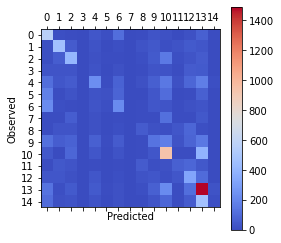

In [49]:
confusion_matrix = plot_confusion_matrix(test_obs_cls, test_pred_cls, labels_dict)

In [55]:
limit = 200
labels_indices_dict = {value:key for key,value in labels_dict.items()}
indices_matrix = np.asmatrix(np.where(confusion_matrix > limit))
misclassified_breeds = []
for i in range(0, indices_matrix.shape[1]):
  breed_1 = labels_indices_dict[indices_matrix[:,i][0].item()]
  breed_2 = labels_indices_dict[indices_matrix[:,i][1].item()]
  breed_tuple = (breed_1, breed_2)
  breed_tuple_rev = (breed_2, breed_1)
  if breed_1 != breed_2 and breed_tuple_rev not in misclassified_breeds:
    misclassified_breeds.append(breed_tuple)

print(f'Rasy o największej liczbie pomyłek (>{limit}): \n')
misclassified_breeds

Rasy o największej liczbie pomyłek (>200): 



[('Samoyed', 'Bichon_Frise'),
 ('golden_retriever', 'teddy'),
 ('toy_poodle', 'teddy')]

# Obliczanie accuracy dla poszczególnych ras

In [56]:
breed_accuracy_df = pd.DataFrame({'observed_class':test_obs_cls, 'predicted_class':test_pred_cls})
breed_accuracy_df['breed_name'] = breed_accuracy_df['observed_class'].map(lambda i: labels_indices_dict[i])
breed_accuracy_df['accurate_pred'] = np.where(breed_accuracy_df['predicted_class']==breed_accuracy_df['observed_class'], 1, 0)

breed_accuracy_df = breed_accuracy_df[['breed_name', 'accurate_pred']].groupby('breed_name') \
                        .mean().sort_values(by='accurate_pred', ascending=False).reset_index()
breed_accuracy_df

,breed_name,accurate_pred
0,teddy,0.667114
1,Bichon_Frise,0.614054
2,Border_collie,0.591784
3,golden_retriever,0.583074
4,Cardigan,0.471936
5,miniature_schnauzer,0.465149
6,Samoyed,0.344985
7,Labrador_retriever,0.216946
8,malamute,0.188442
9,Siberian_husky,0.166667


In [57]:
fig_accuracy_test = px.bar(breed_accuracy_df, x='accurate_pred', y=breed_accuracy_df['breed_name'], orientation='h', title="Accuracy dla poszczególnych ras")
fig_accuracy_test.show()

# Zapisywanie modelu

In [ ]:
model.save("model.h5")
load_saved_model = tf.keras.models.load_model("model.h5")